In [1]:
# % load_ext autoreload
# % autoreload 2
import random
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_NQueens, plot_evolution

# Local Search: Genetic Algorithm

## 1.Generating Phrases

In this section we consider a toy problem: generating a target phrases (e.g. "genetic algorithm") from an initial population of random strings. Assume the length of the target is known.

Problem Formulation: 

1. Direct Representation: just strings.
2. Exponential Search Space: $m^l$ where $m$ is the size of the alphabet (set of characters in our interest) and $l$ is the length of the string.

Now that we want to solve it with GA:
1. Chromosome: directly use the string itself.
2. Fitness: how match/close an individual is to the target.
3. Mating: combine two strings in someway to generate a new one.

The following cells will walk you through this problem to show the basic idea of GA

In [2]:
# setting up the problem
# target = 'Genetic Algorithm'
# u_case = [chr(x) for x in range(65, 91)]
# l_case = [chr(x) for x in range(97, 123)]
# gene_pool = u_case + l_case + [' ']  # all English characters and white spaces


def init_population(pop_size, gene_pool, state_length):
    """
    Randomly initialize a population for genetic algorithm
        pop_size  :  Number of individuals in population
        gene_pool   :  List of possible values for individuals
        state_length:  The length of each individual
    """

    population = []
    for _ in range(pop_size):
        new_individual = "".join(random.choices(gene_pool, k=state_length))
        population.append(new_individual)

    return population

In [3]:
def fitness_fn(sample):
    fitness = 0
    length = len(target)
    for i in range(length):
        fitness += (abs(ord(target[i]) - ord(sample[i])))
    return fitness

In [4]:
class Gene:
    def __init__(self, fitness, value):
        self.fitness = fitness
        self.value = value

    def __cmp__(self, other):
        if self.fitness > other.fitness:
            return -1
        elif self.fitness < other.fitness:
            return 1
        else:
            return 0


def select_min(r, population, fitness_fn):
    """
    TODO: select *r* samples from *population*
    the simplest choice is to sample from *population* with each individual weighted by its fitness
    """
    genes = [Gene(fitness_fn(x), x) for x in population]
    genes = sorted(genes, key=lambda g: g.fitness)
    fitnesses = [g.fitness for g in genes]
    total_fitness = sum(fitnesses)
    select_pop = []
    length = len(fitnesses)
    for j in range(r):
        num = 0
        flag = random.randint(0, total_fitness)
        for i in range(length):
            num += fitnesses[i]
            if num >= flag:
                select_pop.append(genes[length - i - 1].value)
                break
    return select_pop


def select_max(r, population, fitness_fn):
    """
    TODO: select *r* samples from *population*
    the simplest choice is to sample from *population* with each individual weighted by its fitness
    """
    genes = [Gene(fitness_fn(x), x) for x in population]
    genes = sorted(genes, key=lambda g: g.fitness)
    fitnesses = [g.fitness for g in genes]
    total_fitness = sum(fitnesses)
    select_pop = []
    length = len(fitnesses)
    for j in range(r):
        num = 0
        flag = random.randint(0, total_fitness)
        for i in range(length):
            num += fitnesses[i]
            if num >= flag:
                select_pop.append(genes[i].value)
                break
    return select_pop

In [5]:
def recombine(x, y):
    """
    TODO: combine two parents to produce an offspring
    """
    length = len(x)
    flag = random.randint(0, length - 1)
    left = x[:flag]
    right = y[flag:]
    return left + right


def mutate(x, gene_pool, pmut):
    """
    apply mutation to *x* by randomly replacing one of its gene from *gene_pool*
    """
    if random.uniform(0, 1) >= pmut:
        return x

    n = len(x)
    g = len(gene_pool)
    c = random.randrange(0, n)
    r = random.randrange(0, g)

    new_gene = gene_pool[r]
    return x[:c] + new_gene + x[c + 1:]

In [6]:
# now refactor things into a *Problem* abstraction
# you can directly reuse what you have implemented above
from abc import ABC, abstractmethod


class GAProblem(ABC):
    @abstractmethod
    def init_population(self, pop_size): pass

    @abstractmethod
    def fitness(self, sample): pass

    @abstractmethod
    def reproduce(self, population, mutation_rate): pass

    @abstractmethod
    def replacement(self, old, new): pass


class PhraseGeneration(GAProblem):
    def __init__(self, target, alphabet):
        self.target = target
        self.alphabet = alphabet

    def init_population(self, pop_size):
        # raise NotImplementedError()
        return init_population(pop_size, self.alphabet, len(self.target))

    def fitness(self, sample):
        fitness = 0
        length = len(self.target)
        for i in range(length):
            fitness += abs(ord(self.target[i]) - ord(sample[i]))
        return fitness

    def reproduce(self, population, mutation_rate):
        """
        TODO: generate the next generation of population

        hint: make a new individual with 
        
        mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut)

        """
        return [mutate(recombine(*select_min(2, population, self.fitness)), self.alphabet, mutation_rate) for _ in
                range(len(population))]

    def replacement(self, old, new):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """
        return new


def genetic_algorithm_min(
        problem: GAProblem,
        ngen, n_init_size, mutation_rate,
        log_interval=100
):
    population = problem.init_population(n_init_size)
    best = min(population, key=problem.fitness)
    history = [(0, list(map(problem.fitness, population)))]

    for gen in range(ngen):
        next_gen = problem.reproduce(population, mutation_rate)
        population = problem.replacement(population, next_gen)

        if gen % log_interval == 0:
            current_best = min(population, key=problem.fitness)
            if problem.fitness(current_best) < problem.fitness(best):
                best = current_best
            print(f"Generation: {gen}/{ngen},\tBest: {best},\tFitness={problem.fitness(best)}")
            if problem.fitness(best) == 0:
                break
            history.append((gen, list(map(problem.fitness, population))))

    history.append((ngen - 1, list(map(problem.fitness, population))))
    return best, history


def genetic_algorithm_max(
        problem: GAProblem,
        ngen, n_init_size, mutation_rate,
        max_fitness,
        log_interval=100
):
    population = problem.init_population(n_init_size)
    best = max(population, key=problem.fitness)
    history = [(0, list(map(problem.fitness, population)))]

    for gen in range(ngen):
        next_gen = problem.reproduce(population, mutation_rate)
        population = problem.replacement(population, next_gen)

        if gen % log_interval == 0:
            current_best = max(population, key=problem.fitness)
            if problem.fitness(current_best) > problem.fitness(best): best = current_best
            print(f"Generation: {gen}/{ngen},\tBest: {best},\tFitness={problem.fitness(best)}")
            if problem.fitness(best) == max_fitness:
                break
            history.append((gen, list(map(problem.fitness, population))))

    history.append((ngen - 1, list(map(problem.fitness, population))))
    return best, history

In [7]:
# now set up the parameters
ngen = 2500
max_population = 120
mutation_rate = 0.08

sid = 12013006
target = f"Genetic Algorithm by {sid}"
u_case = [chr(x) for x in range(65, 91)]
l_case = [chr(x) for x in range(97, 123)]
digits = [str(i) for i in range(10)]
alphabet = u_case + l_case + digits + [' ']
problem = PhraseGeneration(target, alphabet)

solution, _ = genetic_algorithm_min(problem, ngen, max_population, mutation_rate)
print(solution)

Generation: 0/2500,	Best: CQtJ tWXnuitLvqC44csALDG5WV 0,	Fitness=657
Generation: 100/2500,	Best: JrzavghBCoJtryqgy kpI42 D3I45,	Fitness=273
Generation: 200/2500,	Best: Jczavhu Cogtrkqgy ky342 83245,	Fitness=131
Generation: 300/2500,	Best: Jczavhb Cmgprkugk ez342333245,	Fitness=73
Generation: 400/2500,	Best: Hcnfthb Cmgprhugn ez142323205,	Fitness=45
Generation: 500/2500,	Best: Gdnfthb Amgorhugn cy112023206,	Fitness=30
Generation: 600/2500,	Best: Gdnethb Amgorhuhm cy012023006,	Fitness=24
Generation: 700/2500,	Best: Gdnetic Algoriuhm cy 12023006,	Fitness=4
Generation: 800/2500,	Best: Genetic Algorithm by 12023006,	Fitness=1
Generation: 900/2500,	Best: Genetic Algorithm by 12023006,	Fitness=1
Generation: 1000/2500,	Best: Genetic Algorithm by 12023006,	Fitness=1
Generation: 1100/2500,	Best: Genetic Algorithm by 12023006,	Fitness=1
Generation: 1200/2500,	Best: Genetic Algorithm by 12023006,	Fitness=1
Generation: 1300/2500,	Best: Genetic Algorithm by 12013006,	Fitness=0
Genetic Algorithm by 1

## 2. N-Queens Problem

It is possible to solve the N-Queens problem with slight modifications.

For the problem:

1. Direct Representation: placement of queens.
2. Search Space: $n^n$, if we don't use any constraints.

To use GA:

Actually a new fitness function is the minimum modification you need for this problem.

Others are alomost the same as the previous problem.

In [8]:
def judge(q1: str, q2: str, r1: int, r2: int):
    return (q1 == q2) or (abs(int(q1) - int(q2)) == abs(r1 - r2))

In [9]:
class NQueensProblem(GAProblem):
    def __init__(self, n):
        self.n = n
        self.max_fitness = n * (n - 1) // 2  # max number if non-attacking pairs

    def init_population(self, pop_size):
        # TODO:almost the same as the previous problem.
        return init_population(50, [str(x) for x in range(self.n)], self.n)

    def fitness(self, queens):
        """
        TODO

        hint: count the non-attacking pairs
        """
        fitness = 0
        for i in range(n):
            q1 = queens[i]
            for j in range(i + 1, n):
                q2 = queens[j]
                if not judge(q1, q2, i, j):
                    fitness += 1
        return fitness

    def reproduce(self, population, mutation_rate):
        # TODO:almost the same as the previous problem.
        return [mutate(recombine(*select_max(2, population, self.fitness)), [str(x) for x in range(self.n)], mutation_rate)
                for _ in
                range(len(population))]

    def replacement(self, old, new):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """
        return new

    def __repr__(self):
        return f"{self.n}-Queens Problem"

In [10]:
from utils import plot_NQueens

ngen = 2500
init_size = 120
mutation_rate = 0.08

n = 8
problem = NQueensProblem(n)
solution, history = genetic_algorithm_max(problem, ngen, init_size, mutation_rate, problem.max_fitness)

Generation: 0/2500,	Best: 74604613,	Fitness=24
Generation: 100/2500,	Best: 06427375,	Fitness=26
Generation: 200/2500,	Best: 06627135,	Fitness=27
Generation: 300/2500,	Best: 06627135,	Fitness=27
Generation: 400/2500,	Best: 06627135,	Fitness=27
Generation: 500/2500,	Best: 06627135,	Fitness=27
Generation: 600/2500,	Best: 06627135,	Fitness=27
Generation: 700/2500,	Best: 06627135,	Fitness=27
Generation: 800/2500,	Best: 06627135,	Fitness=27
Generation: 900/2500,	Best: 06627135,	Fitness=27
Generation: 1000/2500,	Best: 06627135,	Fitness=27
Generation: 1100/2500,	Best: 06627135,	Fitness=27
Generation: 1200/2500,	Best: 06627135,	Fitness=27
Generation: 1300/2500,	Best: 06627135,	Fitness=27
Generation: 1400/2500,	Best: 06627135,	Fitness=27
Generation: 1500/2500,	Best: 40357162,	Fitness=28


D:\1A\Python lab\2022-Fall-AI-Practice\Practice7\utils.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


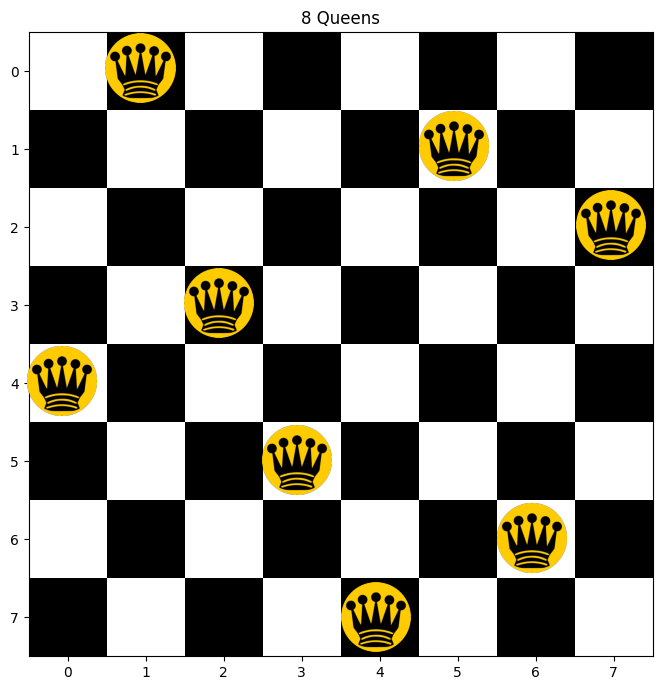

In [11]:
# Example of how to use this function
# plot_NQueens([4, 2, 0, 6, 1, 7, 5, 3])
# replace the parameter with your own results
solution = [int(s) for s in solution]
plot_NQueens(solution)

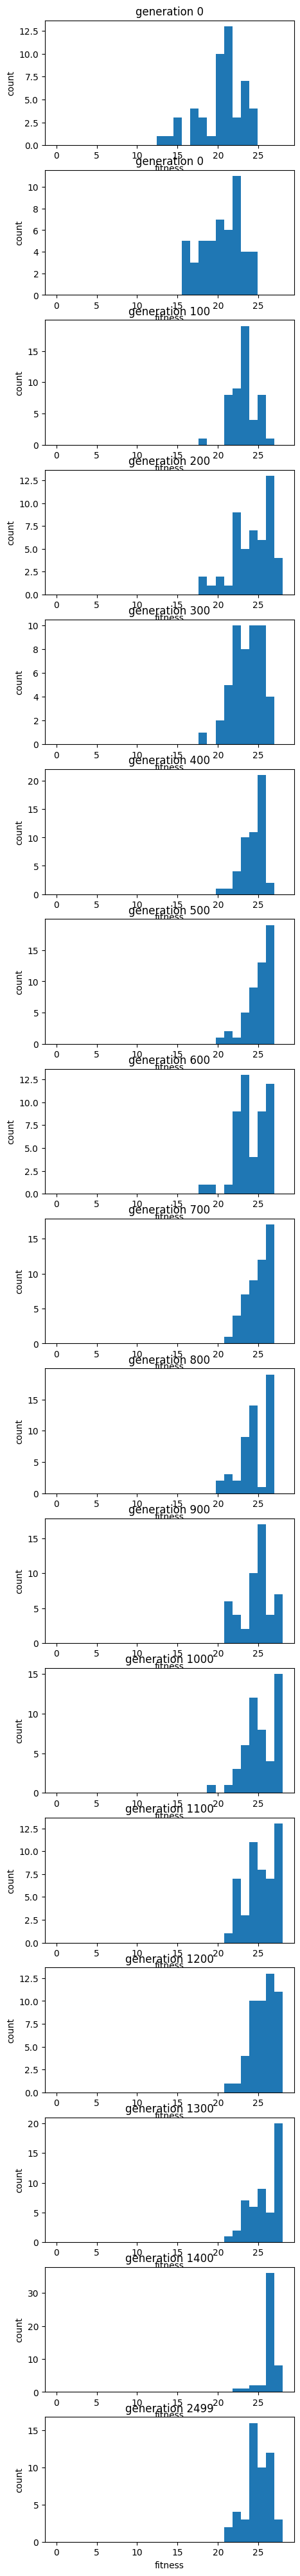

In [12]:
# Visualize the evolution of the population
bins = np.linspace(0, problem.max_fitness, problem.max_fitness)
plot_evolution(history, bins)